# **Zero shot transfer learning with CLIP model**

## **Setup**

In [1]:

!pip install torch torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git



  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import clip
from PIL import Image
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt


## **Loading the CLIP Model**

In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 133MiB/s]


## **Downloading and Preprocessing Images**


100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


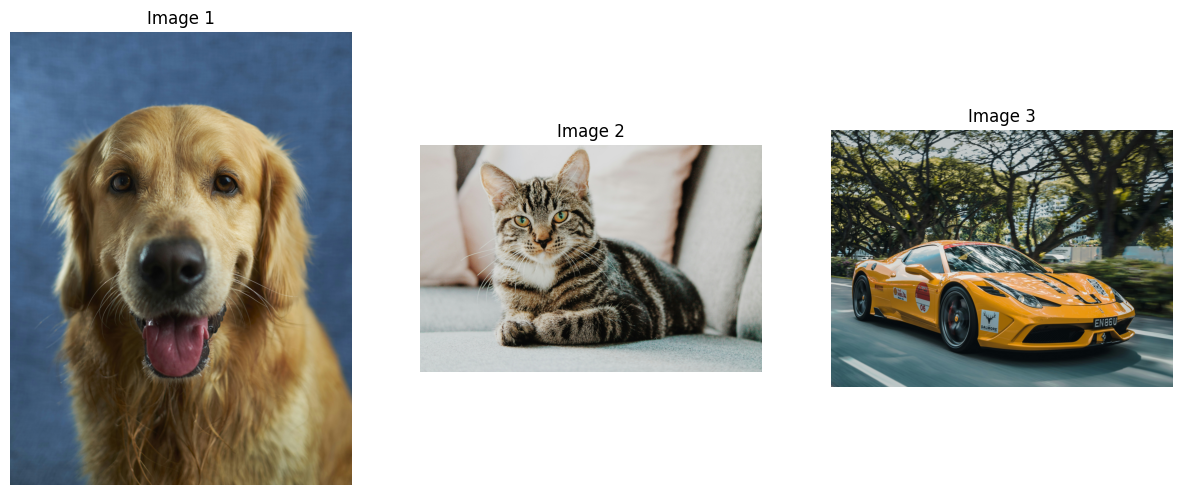

In [9]:

# URLs of sample images
image_urls = [
    "https://images.unsplash.com/photo-1558788353-f76d92427f16",  # An image of a dog
    "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",  # An image of a cat
    "https://images.unsplash.com/photo-1503736334956-4c8f8e92946d"   # An image of a train
]

images = [preprocess(Image.open(urllib.request.urlopen(url))).unsqueeze(0).to(device) for url in tqdm(image_urls)]

# Display images
fig, axs = plt.subplots(1, len(images), figsize=(15, 15))
for i, img in enumerate(images):
    img_show = Image.open(urllib.request.urlopen(image_urls[i]))
    axs[i].imshow(img_show)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')


## **Defining Text Prompts for Zero-Shot Classification**

In [10]:

text_prompts = ["a photo of a dog", "a photo of a cat", "a photo of a car"]

# Preprocess text prompts
text_tokens = clip.tokenize(text_prompts).to(device)


## **Making Predictions with CLIP**

In [12]:
# Cell 6: Make Predictions

with torch.no_grad():
    # Calculate image features
    image_features = torch.cat([model.encode_image(image) for image in images])

    # Calculate text features
    text_features = model.encode_text(text_tokens)

    # Calculate logits and apply the logit scale for each pair of image and text features
    logits_per_image = (image_features @ text_features.t()) * model.logit_scale.exp()

    # Convert logits to probabilities
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Display the results
    for i, url in enumerate(image_urls):
        print(f"Results for Image {i+1}:")
        for j, prompt in enumerate(text_prompts):
            print(f"{prompt}: {probs[i, j]:.5f}")


Results for Image 1:
a photo of a dog: 1.00000
a photo of a cat: 0.00000
a photo of a car: 0.00000
Results for Image 2:
a photo of a dog: 0.00000
a photo of a cat: 1.00000
a photo of a car: 0.00000
Results for Image 3:
a photo of a dog: 0.00000
a photo of a cat: 0.00000
a photo of a car: 1.00000


# **Transfer learning using state of art models from tfhub**

## **Setup**

In [15]:

!pip install tensorflow tensorflow_hub tensorflow_datasets


In [16]:

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## **Downloading and Preparing the Dataset**

In [17]:

(train_ds, validation_ds), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

def format_image(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

batch_size = 32
train_ds = train_ds.map(format_image).batch(batch_size).prefetch(1)
validation_ds = validation_ds.map(format_image).batch(batch_size).prefetch(1)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


## **Pre-Trained Model from TensorFlow Hub**

In [18]:

model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
base_model = hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)


## **Building and Compiling the Model**

In [19]:

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(dataset_info.features['label'].num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## **Training the Model**

In [20]:

epochs = 10
history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs)


Epoch 1/10
81/81 [==============================] - 143s 2s/step - loss: 1.4312 - accuracy: 0.4095 - val_loss: 1.2424 - val_accuracy: 0.5159
Epoch 2/10
81/81 [==============================] - 125s 2s/step - loss: 1.1711 - accuracy: 0.5504 - val_loss: 1.1410 - val_accuracy: 0.5713
Epoch 3/10
81/81 [==============================] - 128s 2s/step - loss: 1.0709 - accuracy: 0.6002 - val_loss: 1.0921 - val_accuracy: 0.5876
Epoch 4/10
81/81 [==============================] - 118s 1s/step - loss: 1.0061 - accuracy: 0.6255 - val_loss: 1.0625 - val_accuracy: 0.6022
Epoch 5/10
81/81 [==============================] - 116s 1s/step - loss: 0.9578 - accuracy: 0.6466 - val_loss: 1.0427 - val_accuracy: 0.6049
Epoch 6/10
81/81 [==============================] - 123s 2s/step - loss: 0.9191 - accuracy: 0.6617 - val_loss: 1.0285 - val_accuracy: 0.6049
Epoch 7/10
81/81 [==============================] - 124s 2s/step - loss: 0.8868 - accuracy: 0.6757 - val_loss: 1.0179 - val_accuracy: 0.6094
Epoch 8/10
81

## **Visualizations**

35/35 [==============================] - 35s 981ms/step - loss: 0.9985 - accuracy: 0.6240
Validation Accuracy: 62.40%


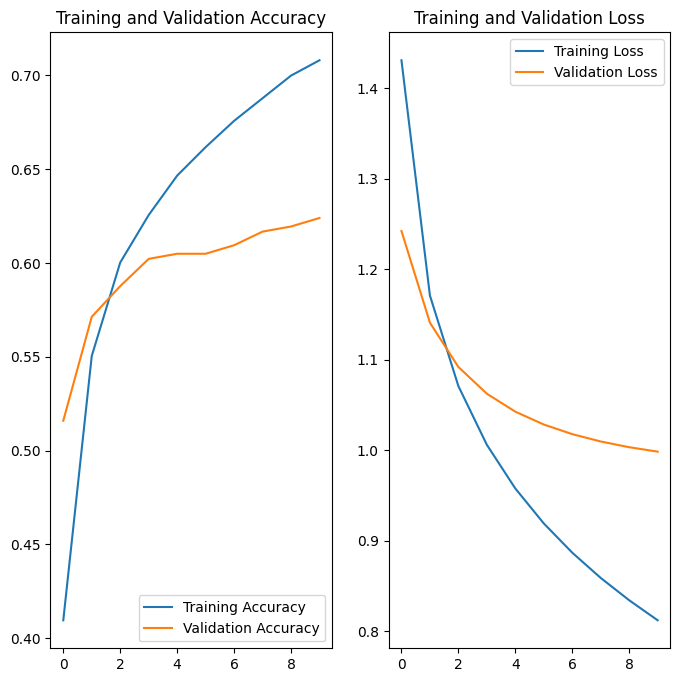

In [21]:

val_loss, val_accuracy = model.evaluate(validation_ds)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plotting training results
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
